In [1]:
"""
Notebook Comparativo: Markowitz Clássico vs Regressão Linear vs MLP
====================================================================

Este notebook compara três abordagens de otimização de portfólios:
1. Markowitz Clássico (média histórica)
2. Markowitz com Regressão Linear
3. Markowitz com MLP (Multi-Layer Perceptron)

Gera:
- Previsões de retornos (mu)
- Pesos ótimos dos portfólios
- Métricas financeiras (Sharpe, retorno, volatilidade)
- Gráficos comparativos
- CSVs com resultados
"""

import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuração de estilo (compatibilidade)
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")

# Imports principais
from src.data.loader import load_prices, compute_returns
from src.data.asset_selection import (
    get_brazilian_stocks_universe,
    #select_assets_from_universe,
    get_correlation_matrix
)
from src.models.lr import predict_mean_returns
from src.optimization.markowitz import solve_markowitz, portfolio_return, portfolio_volatility
from src.optimization.evaluation import (
    evaluate_portfolio,
    calculate_sharpe_ratio,
    calculate_annualized_return,
    calculate_annualized_volatility
)
from src.utils.visualization import (
    plot_efficient_frontier_comparison,
    plot_portfolio_timeseries,
    plot_covariance_heatmap,
    plot_predicted_returns_histogram,
    plot_sharpe_comparison
)
from src.utils.export import (
    save_portfolio_metrics,
    save_portfolio_weights,
    save_predicted_returns,
    save_all_metrics_comparison
)
from src.utils.portfolio_utils import get_optimal_portfolio_max_sharpe
from outputs.charts.markowitz_plot import compare_frontiers

# Configuração de diretórios
OUTPUTS_DIR = Path("../outputs")
CHARTS_DIR = OUTPUTS_DIR / "charts"
MODELS_DIR = OUTPUTS_DIR / "models"
PREDICTIONS_DIR = OUTPUTS_DIR / "predictions"

# Criar diretórios se não existirem
CHARTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
PREDICTIONS_DIR.mkdir(parents=True, exist_ok=True)

print("  Imports concluídos e diretórios criados") 




  Imports concluídos e diretórios criados


## 1. Configuração dos Parâmetros

### 1.1. Parâmetros de Seleção de Ativos

In [2]:

# CONFIGURAÇÕES DO EXPERIMENTO

# Período de análise
start_date = "2010-01-01"
end_date = "2025-01-01"

# Configurações de seleção automática de ativos
USE_AUTOMATIC_SELECTION = True  # Se False, usa lista manual de tickers
N_SELECTED_ASSETS = 10  # Número de ativos a selecionar
SELECTION_METHOD = "sum_abs_correlation"  # "sum_abs_correlation" ou "min_max_correlation"
MIN_DATA_COVERAGE = 0.8  # Proporção mínima de dados não-nulos (0.0 a 1.0)

# Lista manual de ativos (usada apenas se USE_AUTOMATIC_SELECTION = False)
MANUAL_TICKERS = [
    "PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"
]

# Parâmetros dos modelos
window = 24  # Janela de features (lags)
alpha_blend = 0.3  # Blending: 0.0 = sem correção, 1.0 = apenas previsão

# Taxa livre de risco (Selic anual, aproximadamente 15% ao ano em 2025)
RISK_FREE_RATE_ANNUAL = 0.15

# Períodos por ano (mensal = 12)
# NOTA: Estamos usando retornos MENSALAIS, então PERIODS_PER_YEAR = 12
PERIODS_PER_YEAR = 12

# Taxa livre de risco no período mensal (convertida de anual para mensal)
risk_free_rate_period = (1 + RISK_FREE_RATE_ANNUAL) ** (1 / PERIODS_PER_YEAR) - 1

print("Configuracao:")
print(f"   - Selecao automatica: {USE_AUTOMATIC_SELECTION}")
if USE_AUTOMATIC_SELECTION:
    print(f"   - Numero de ativos a selecionar: {N_SELECTED_ASSETS}")
    print(f"   - Metodo de selecao: {SELECTION_METHOD}")
    print(f"   - Cobertura minima de dados: {MIN_DATA_COVERAGE*100:.0f}%")
else:
    print(f"   - Ativos manuais: {len(MANUAL_TICKERS)}")
print(f"   - Periodo: {start_date} a {end_date}")
print(f"   - Janela: {window} periodos")
print(f"   - Alpha blend: {alpha_blend}")
print(f"   - Taxa livre de risco: {RISK_FREE_RATE_ANNUAL*100:.1f}% a.a. (Selic)")
print(f"   - Taxa livre de risco mensal: {risk_free_rate_period*100:.4f}% a.m.")
print(f"   - Escala: MENSAL (PERIODS_PER_YEAR = {PERIODS_PER_YEAR})")


Configuracao:
   - Selecao automatica: True
   - Numero de ativos a selecionar: 10
   - Metodo de selecao: sum_abs_correlation
   - Cobertura minima de dados: 80%
   - Periodo: 2010-01-01 a 2025-01-01
   - Janela: 24 periodos
   - Alpha blend: 0.3
   - Taxa livre de risco: 15.0% a.a. (Selic)
   - Taxa livre de risco mensal: 1.1715% a.m.
   - Escala: MENSAL (PERIODS_PER_YEAR = 12)


## 2. Seleção Automática de Ativos

Esta seção seleciona automaticamente os ativos menos correlacionados a partir de um universo maior de ações brasileiras.

In [3]:
# Seleção automática ou manual de ativos
from src.data.asset_selection import select_assets


if USE_AUTOMATIC_SELECTION:
    print("Selecao automatica de ativos")
    print("=" * 60)
    
    # Obter universo de ações brasileiras
    universe_tickers = get_brazilian_stocks_universe()
    print(f"Universo de ativos: {len(universe_tickers)} acoes brasileiras")
    
    # Selecionar ativos menos correlacionados
    # tickers = select_assets_from_universe(
    #     universe_tickers=universe_tickers,
    #     start_date=start_date,
    #     end_date=end_date,
    #     n_assets=N_SELECTED_ASSETS,
    #     method=SELECTION_METHOD,
    #     min_data_coverage=MIN_DATA_COVERAGE,
    #     return_freq="monthly"
    # )
    tickers = select_assets(
        start_date="2010-01-01",
        end_date="2025-01-01",
        method="stable_corr_pairs",
        n_assets=10
    )
    
    print(f"\nAtivos selecionados ({len(tickers)}):")
    for i, ticker in enumerate(tickers, 1):
        print(f"  {i}. {ticker}")
    
else:
    print("Usando lista manual de ativos")
    tickers = MANUAL_TICKERS
    print(f"Ativos: {', '.join(tickers)}")

print("\n" + "=" * 60)

Selecao automatica de ativos
Universo de ativos: 39 acoes brasileiras
  Aviso: CAML3.SA removido - dados insuficientes (1805/3724 periodos)
  Aviso: KLBN11.SA removido - dados insuficientes (2720/3724 periodos)

Ativos selecionados (10):
  1. PETR3.SA
  2. WEGE3.SA
  3. TOTS3.SA
  4. VALE3.SA
  5. EMBR3.SA
  6. VIVT3.SA
  7. CSNA3.SA
  8. RADL3.SA
  9. PCAR3.SA
  10. PINE4.SA



## 3. Carregamento e Preparação dos Dados


In [4]:
# Carregar preços históricos dos ativos selecionados
print("Carregando dados do Yahoo Finance...")
prices = load_prices(tickers, start=start_date, end=end_date, min_data_coverage=MIN_DATA_COVERAGE)

# Validar que temos dados
if prices.empty or len(prices) == 0:
    raise ValueError(
        f"Nenhum dado foi carregado para os ativos selecionados. "
        f"Verifique se os tickers estao corretos e se ha dados disponiveis no periodo."
    )

# Atualizar lista de tickers para apenas os que têm dados
tickers = [t for t in tickers if t in prices.columns]
if len(tickers) < len(prices.columns):
    print(f"  Aviso: Alguns ativos foram removidos por falta de dados")
    print(f"  Ativos validos: {', '.join(tickers)}")

print(f"  Dados carregados: {prices.shape[0]} dias, {prices.shape[1]} ativos")
if len(prices) > 0:
    print(f"   Periodo: {prices.index[0].date()} a {prices.index[-1].date()}")


Carregando dados do Yahoo Finance...
  Dados carregados: 3724 dias, 10 ativos
   Periodo: 2010-01-04 a 2024-12-30


In [5]:
# Calcular retornos mensais
returns = compute_returns(prices, freq='monthly')
print(f"  Retornos mensais calculados: {returns.shape[0]} meses")
print(f"\nEstatisticas descritivas dos retornos:")
print(returns.describe().round(4))

# Visualizar matriz de correlação dos ativos selecionados
if USE_AUTOMATIC_SELECTION:
    print("\nMatriz de correlacao dos ativos selecionados:")
    corr_matrix = get_correlation_matrix(returns, selected_assets=tickers)
    print(corr_matrix.round(3))

  Retornos mensais calculados: 179 meses

Estatisticas descritivas dos retornos:
Ticker  CSNA3.SA  EMBR3.SA  PCAR3.SA  PETR3.SA  PINE4.SA  RADL3.SA  TOTS3.SA  \
count   179.0000  179.0000  179.0000  179.0000  179.0000  179.0000  179.0000   
mean      0.0129    0.0163    0.0194    0.0150    0.0091    0.0184    0.0124   
std       0.1751    0.1095    0.2309    0.1245    0.1358    0.0803    0.0892   
min      -0.5023   -0.4375   -0.7614   -0.4792   -0.4753   -0.1494   -0.3426   
25%      -0.0986   -0.0414   -0.0010   -0.0639   -0.0599   -0.0401   -0.0490   
50%      -0.0108   -0.0001    0.0000    0.0086   -0.0075    0.0246    0.0088   
75%       0.1114    0.0664    0.0120    0.0863    0.0644    0.0755    0.0774   
max       0.8429    0.3914    2.0191    0.4875    0.8693    0.1910    0.3161   

Ticker  VALE3.SA  VIVT3.SA  WEGE3.SA  
count   179.0000  179.0000  179.0000  
mean      0.0100    0.0097    0.0217  
std       0.1002    0.0581    0.0814  
min      -0.2778   -0.1144   -0.2213  
25%

## 3.1. Visualização da Matriz de Correlação dos Ativos Selecionados


In [6]:
# GRÁFICO 0: Matriz de Correlação dos Ativos Selecionados

if USE_AUTOMATIC_SELECTION:
    print("Gerando heatmap da matriz de correlacao dos ativos selecionados...")
    corr_matrix_selected = get_correlation_matrix(returns, selected_assets=tickers)
    plot_covariance_heatmap(
        corr_matrix_selected,
        save_path=str(CHARTS_DIR / "selected_assets_correlation_heatmap.png"),
        figsize=(12, 10)
    )


Gerando heatmap da matriz de correlacao dos ativos selecionados...


Gráfico salvo em: ../outputs/charts/selected_assets_correlation_heatmap.png


## 3. Treinamento dos Modelos Preditivos

Agora vamos treinar os modelos de Regressão Linear e MLP para prever os retornos esperados (mu).

## 4.1. Visualização da Matriz de Covariância


In [7]:

# MODELO 1: REGRESSÃO LINEAR

print("Treinando Regressão Linear...")
pred_lr_monthly, split_idx, pure_monthly, cov_monthly = predict_mean_returns(
    returns, 
    window=window, 
    alpha_blend=alpha_blend, 
    model_machine_learning='Ridge'
)
print(f"  Regressão Linear concluída")
print(f"   Split treino/teste: {split_idx} meses ({split_idx/len(returns)*100:.1f}% treino)")


# MODELO 2: MLP (Multi-Layer Perceptron)

print("\n Treinando MLP...")
pred_mlp_monthly, _, _, _ = predict_mean_returns(
    returns, 
    window=window, 
    alpha_blend=alpha_blend, 
    model_machine_learning='MLPRegressor'
)
print(f"  MLP concluído")


# MODELO 3: MARKOWITZ CLÁSSICO (média histórica)

print("\n Markowitz Clássico (média histórica)")
print(f"  Usando média histórica do período de treino")

print(f"\n mo das previsões:")
print(f"\n{'Ativo':<12} {'LR (mu)':<12} {'MLP (mu)':<12} {'Histórico (mu)':<15}")
print("-" * 55)
for ticker in returns.columns:
    print(f"{ticker:<12} {pred_lr_monthly[ticker]:>10.6f}  {pred_mlp_monthly[ticker]:>10.6f}  {pure_monthly[ticker]:>13.6f}") 

Treinando Regressão Linear...
Ativo: CSNA3.SA - Retorno Médio Previsto: 0.023651 - Retorno Médio Real: 0.012922.
Ativo: EMBR3.SA - Retorno Médio Previsto: 0.002605 - Retorno Médio Real: 0.016316.
Ativo: PCAR3.SA - Retorno Médio Previsto: 0.014608 - Retorno Médio Real: 0.019390.
Ativo: PETR3.SA - Retorno Médio Previsto: 0.012602 - Retorno Médio Real: 0.015006.
Ativo: PINE4.SA - Retorno Médio Previsto: -0.004034 - Retorno Médio Real: 0.009062.
Ativo: RADL3.SA - Retorno Médio Previsto: 0.022570 - Retorno Médio Real: 0.018395.
Ativo: TOTS3.SA - Retorno Médio Previsto: 0.017923 - Retorno Médio Real: 0.012439.
Ativo: VALE3.SA - Retorno Médio Previsto: 0.016262 - Retorno Médio Real: 0.010034.
Ativo: VIVT3.SA - Retorno Médio Previsto: 0.007912 - Retorno Médio Real: 0.009729.
Ativo: WEGE3.SA - Retorno Médio Previsto: 0.033190 - Retorno Médio Real: 0.021661.
  Regressão Linear concluída
   Split treino/teste: 108 meses (60.3% treino)

 Treinando MLP...
Ativo: CSNA3.SA - Retorno Médio Previsto: 0

In [8]:
# GRÁFICO 1: Histograma das Previsões de Retornos

print("\n  Gerando histograma das previsões de retornos...")
plot_predicted_returns_histogram(
    pred_lr_monthly,
    pred_mlp_monthly,
    save_path=str(CHARTS_DIR / "predicted_returns_histogram.png"),
    figsize=(14, 6)
)



  Gerando histograma das previsões de retornos...
Gráfico salvo em: ../outputs/charts/predicted_returns_histogram.png


In [9]:
# GRÁFICO 2: Heatmap da Matriz de Covariância

print("\n  Gerando heatmap da matriz de covariância...")
plot_covariance_heatmap(
    cov_monthly,
    save_path=str(CHARTS_DIR / "covariance_heatmap.png"),
    figsize=(12, 10)
)



  Gerando heatmap da matriz de covariância...
Gráfico salvo em: ../outputs/charts/covariance_heatmap.png


## 4. Otimização de Portfólios (Markowitz)

Agora vamos otimizar os portfólios usando os três conjuntos de retornos esperados (mu).

In [10]:

# CONSTRUÇÃO DOS MODELOS PARA COMPARAÇÃO


models = [
    {
        "name": "Markowitz Classico",
        "mean_returns": pure_monthly,
        "cov": cov_monthly,
        "color": "blue",
        "linestyle": "-",
    },
    {
        "name": "Markowitz + Regressao Linear",
        "mean_returns": pred_lr_monthly,
        "cov": cov_monthly,
        "color": "orange",
        "linestyle": "--",
    },
    {
        "name": "Markowitz + MLP",
        "mean_returns": pred_mlp_monthly,
        "cov": cov_monthly,
        "color": "green",
        "linestyle": "-.",
    },
]

print("  Modelos configurados para comparação")

  Modelos configurados para comparação


## 5.1. Visualização das Fronteiras Eficientes


In [11]:
# GRÁFICO 3: Comparação das Fronteiras Eficientes

print("\n  Gerando gráfico de comparação das fronteiras eficientes...")
plot_efficient_frontier_comparison(
    models,
    save_path=str(CHARTS_DIR / "efficient_frontier_comparison.png"),
    figsize=(12, 8)
)



  Gerando gráfico de comparação das fronteiras eficientes...
Gráfico salvo em: ../outputs/charts/efficient_frontier_comparison.png


## 5.1.1. Nota sobre Gráficos Teóricos vs. Realizados

**IMPORTANTE:** Os gráficos de fronteiras eficientes mostram curvas **TEÓRICAS** baseadas nos retornos esperados (μ) e covariâncias estimadas pelos modelos. 

**Por que os gráficos podem mostrar MLP como "superior"?**
- O MLP prevê retornos esperados (μ) mais altos para vários ativos
- Isso faz com que a fronteira eficiente **teórica** do MLP fique acima das outras
- Porém, essas previsões são **ex-ante** (antes de ver os dados reais)

**Por que as métricas podem divergir dos gráficos?**
- As métricas são calculadas com **dados reais** (out-of-sample)
- Se o MLP superestima retornos, a fronteira teórica é bonita, mas o desempenho real pode ser inferior
- Isso é um fenômeno comum: modelos complexos podem ter **overfitting** ou **otimismo excessivo**

**Interpretação correta:**
- Gráficos de fronteiras = o que o modelo "acredita" que vai acontecer (ex-ante)
- Métricas de performance = o que realmente aconteceu (ex-post)
- A divergência entre eles é um achado importante sobre a qualidade das previsões


# Solve Markowitz once

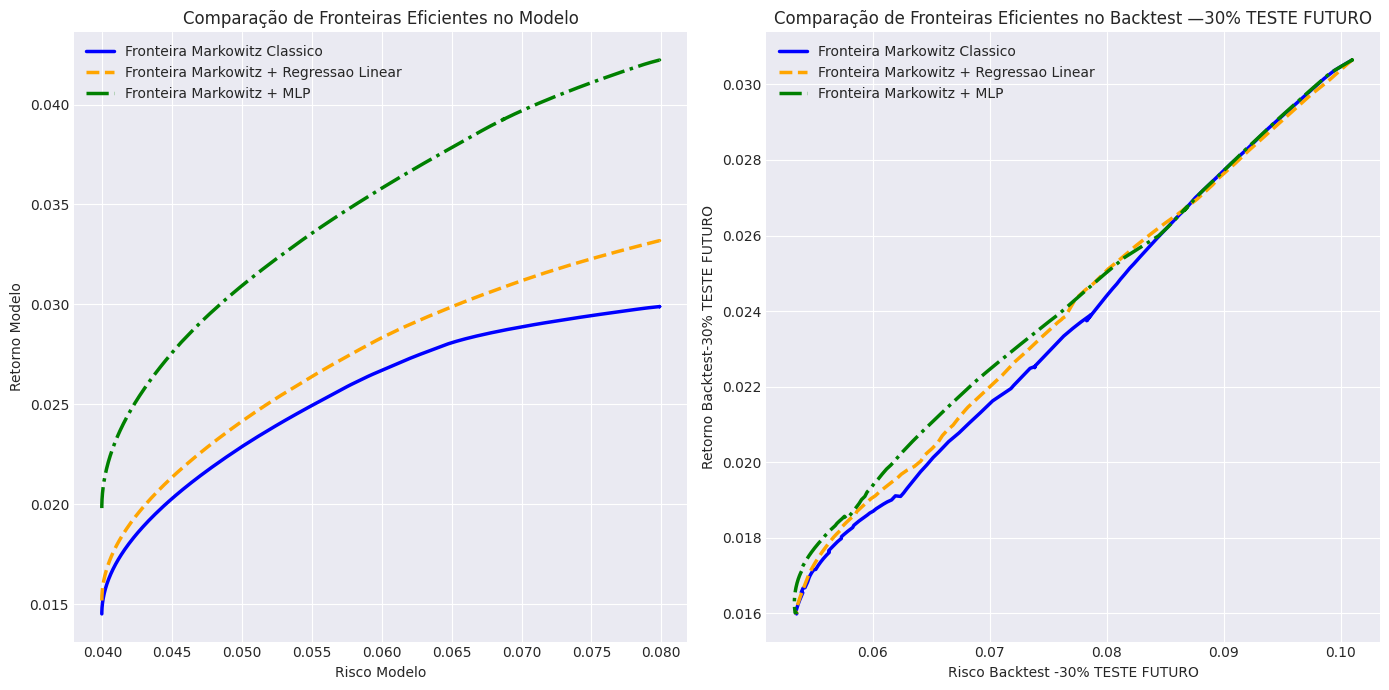

In [12]:
ret_curve, vol_curve, lambdas, w_list = compare_frontiers(models, window=window, returns_monthly=returns, split_idx=split_idx)

## 6. Visualização Temporal dos Portfólios


In [13]:
# GRÁFICO 4: Comparação Temporal dos Portfólios (usando risco médio)

# Calcular risco médio para usar como target
target_risk_mean = np.mean([np.mean(vol_curve[i]) for i in range(len(vol_curve))])

print(f"\n  Gerando gráfico de comparação temporal dos portfólios...")
print(f"   Target Risk: {target_risk_mean:.4f}")

plot_portfolio_timeseries(
    models,
    returns,
    split_idx,
    target_risk=target_risk_mean,
    lambdas=lambdas,
    w_list=w_list,
    ret_curve=ret_curve,
    vol_curve=vol_curve,
    save_path=str(CHARTS_DIR / "portfolio_timeseries_comparison.png"),
    figsize=(14, 8)
)



  Gerando gráfico de comparação temporal dos portfólios...
   Target Risk: 0.0512
Gráfico salvo em: ../outputs/charts/portfolio_timeseries_comparison.png


## 7. Análise de Sensibilidade por Níveis de Risco


In [14]:
from outputs.charts.markowitz_plot import (
    find_lambda_for_risk,
    solve_markowitz,
    portfolio_volatility,
    portfolio_return
)
from src.optimization.markowitz import solve_markowitz, portfolio_return, portfolio_volatility

# from src.data.loader import load_prices, compute_returns
# from src.models.lr import predict_mean_returns
# from outputs.charts.markowitz_plot import compare_time_series, compare_frontiers
# from outputs.charts.models_markowitz import plot_LR_parity_return_prediction, plot_LR_parity_by_all_assets

def compare_time_series_local(
    models: list,
    target_risk: float = 0.014,
    w_list: list = None,
    lambdas: list = None,
    ret_curve: list = None,
    vol_curve: list = None,
):
    """
    Compara o crescimento acumulado mensal de N modelos.

    Cada item de 'models':
    {
        "name": str,
        "mean_returns": pd.Series,
        "cov": pd.DataFrame,
        "color": str,
        "linestyle": str
    }
    """

    plt.figure(figsize=(14, 8))
    counter = 0
    for model in models:

        name = model["name"]
        mean = model["mean_returns"]
        cov = model["cov"]


        lamb = None
        min_diff = 10e10
        for i, lambd in enumerate(lambdas):
            if np.abs(vol_curve[counter][i] - target_risk) <= min_diff:
                min_diff = np.abs(vol_curve[counter][i] - target_risk)
                lamb = lambd


        index_lamb = lambdas.tolist().index(lamb)
        weights = w_list[counter][index_lamb]


        port = returns[split_idx:].dot(weights)

        print("Lambda {}, Name: {}, Volatility: {:.4f}, Mean Return: {:.4f}".format(lamb, name, port.std(), port.mean()   ))

        # print("Actual mean return: {}".format(portfolio_return(weights, port.mean() )))

        # port = returns[split_idx:].dot(weights)
        # print("Actual return: {}".format(port.mean())) 


        acum = (1 + returns[split_idx:].dot(weights)).cumprod()
        plt.plot(
            acum.index, acum,
            # acum.index, acum,
            label=name,
            linewidth=2,
            color=model["color"],
            linestyle=model["linestyle"],
            # marker='o', markersize=5
        )
        counter += 1

    plt.title("Comparação Temporal dos Portfólios (Backtest). Target Risk: {:.4f}".format(target_risk))
    plt.xlabel("Tempo (Mensal)")
    plt.ylabel("Crescimento Acumulado")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [15]:
np.min( [np.min(vol_curve[0]), np.min(vol_curve[1])]  )

np.float64(0.03995933588764251)

In [16]:
min_risk = np.max( [np.min(vol_curve[0]), np.min(vol_curve[1])]  )
max_risk = np.min( [np.max(vol_curve[0]), np.max(vol_curve[1])]  )

Lambda 0.985, Name: Markowitz Classico, Volatility: 0.0534, Mean Return: 0.0160
Lambda 0.985, Name: Markowitz + Regressao Linear, Volatility: 0.0534, Mean Return: 0.0160
Lambda 1.0, Name: Markowitz + MLP, Volatility: 0.0535, Mean Return: 0.0160


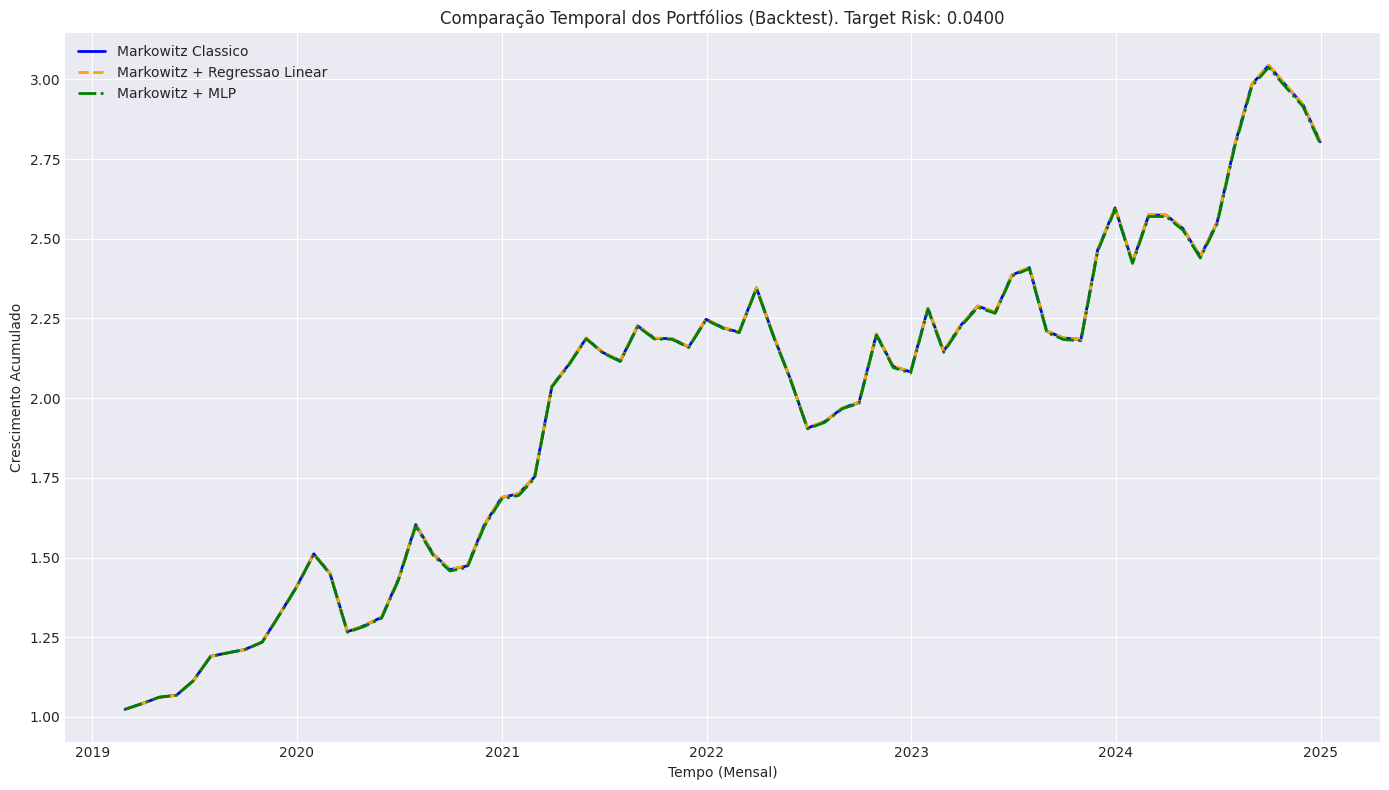

Lambda 0.31, Name: Markowitz Classico, Volatility: 0.0641, Mean Return: 0.0197
Lambda 0.33, Name: Markowitz + Regressao Linear, Volatility: 0.0651, Mean Return: 0.0204
Lambda 0.37, Name: Markowitz + MLP, Volatility: 0.0634, Mean Return: 0.0206


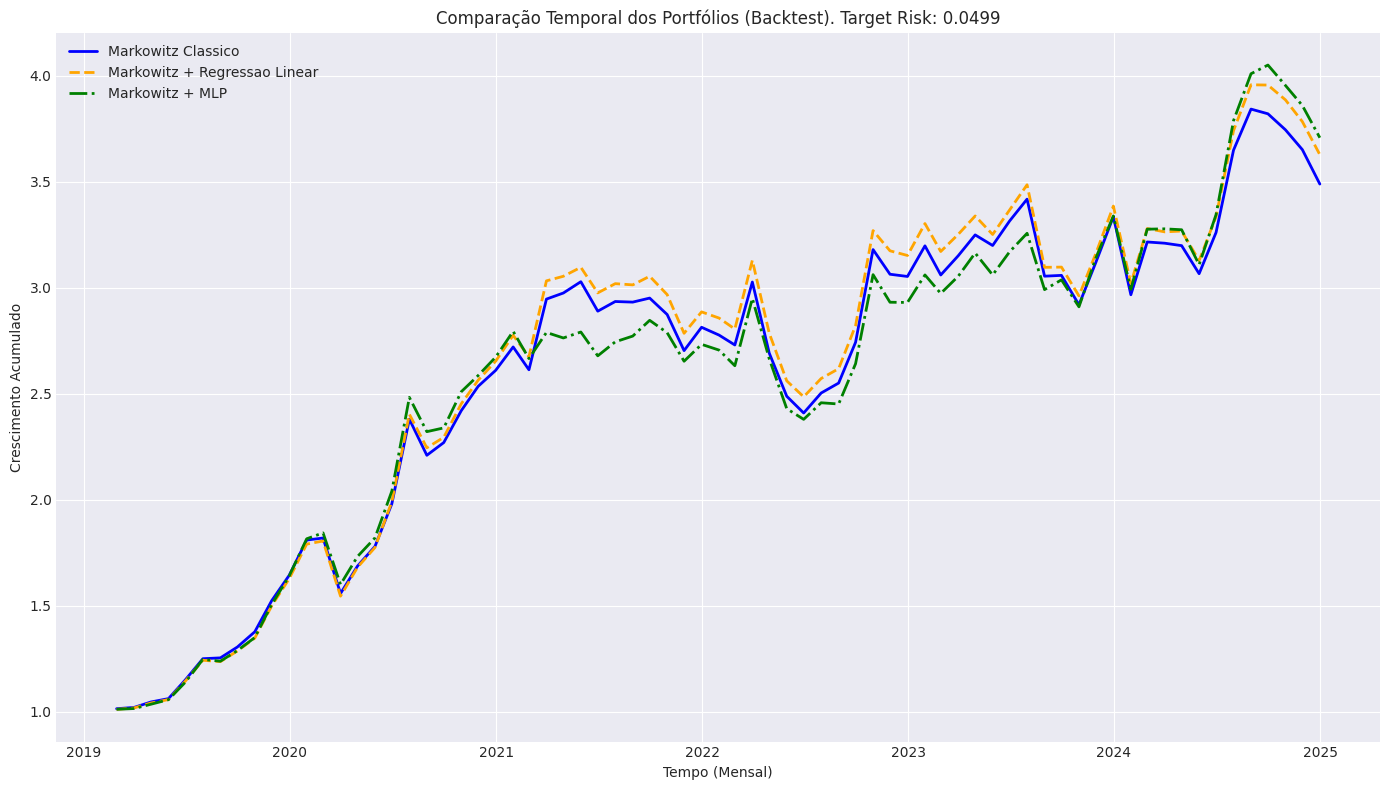

Lambda 0.23, Name: Markowitz Classico, Volatility: 0.0739, Mean Return: 0.0225
Lambda 0.265, Name: Markowitz + Regressao Linear, Volatility: 0.0762, Mean Return: 0.0238
Lambda 0.295, Name: Markowitz + MLP, Volatility: 0.0759, Mean Return: 0.0239


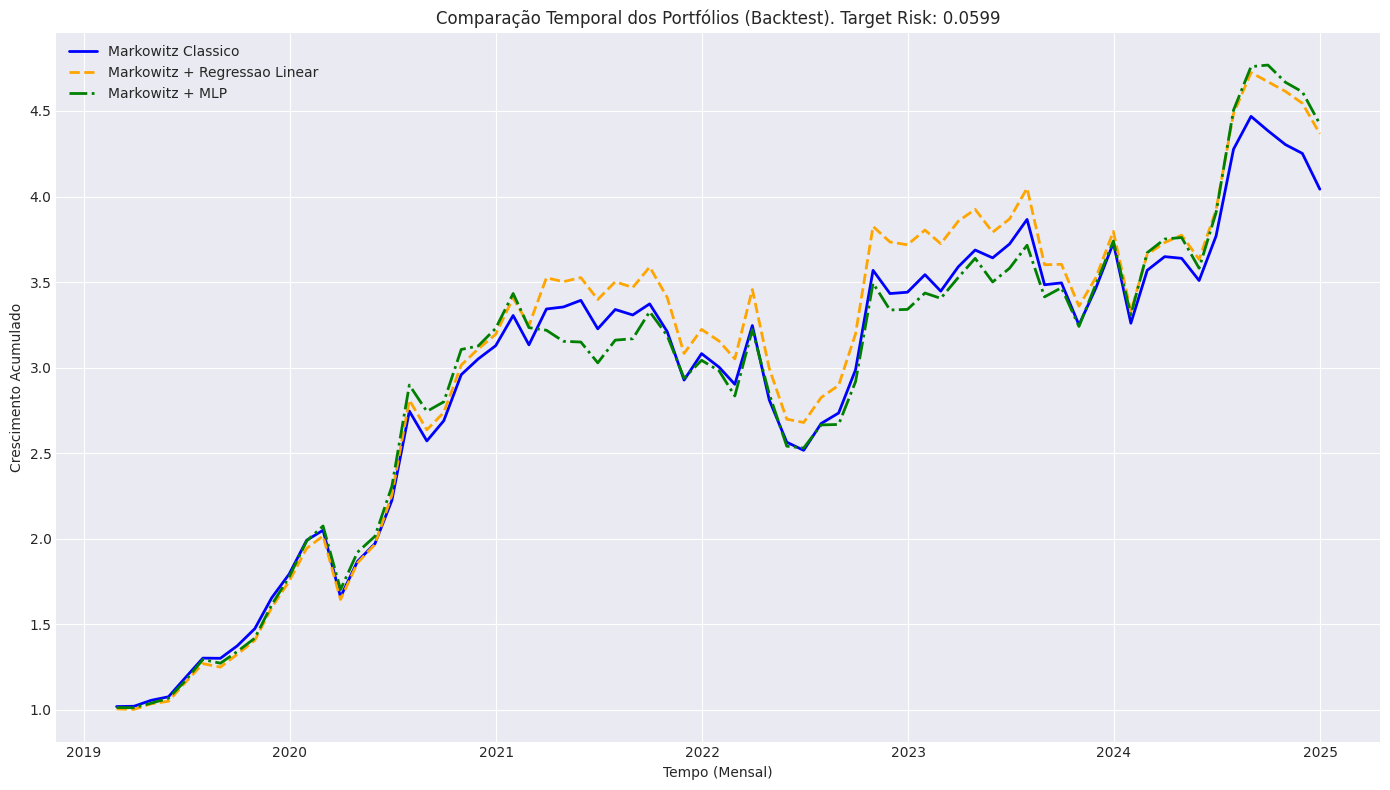

Lambda 0.115, Name: Markowitz Classico, Volatility: 0.0876, Mean Return: 0.0270
Lambda 0.195, Name: Markowitz + Regressao Linear, Volatility: 0.0890, Mean Return: 0.0273
Lambda 0.24, Name: Markowitz + MLP, Volatility: 0.0882, Mean Return: 0.0272


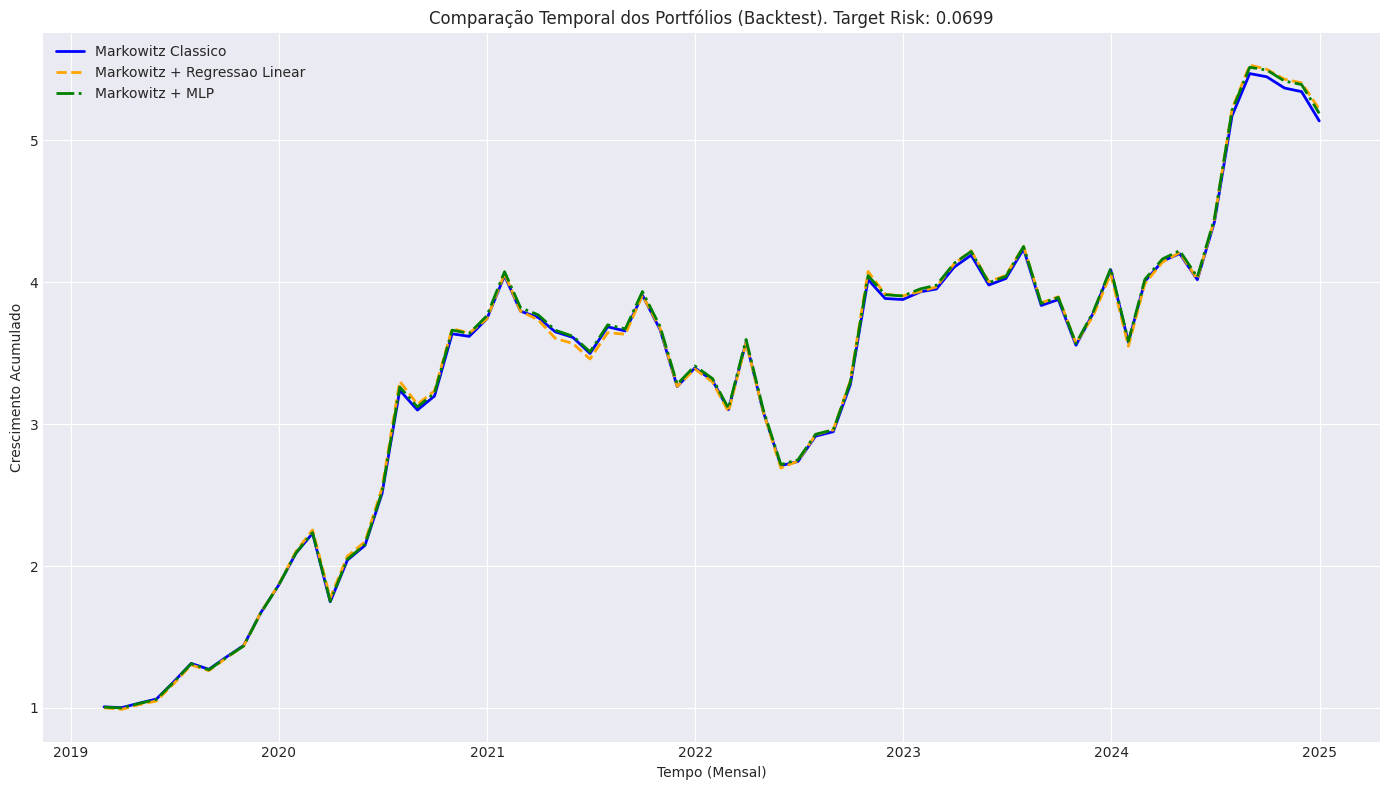

Lambda 0.055, Name: Markowitz Classico, Volatility: 0.1010, Mean Return: 0.0306
Lambda 0.12, Name: Markowitz + Regressao Linear, Volatility: 0.1010, Mean Return: 0.0306
Lambda 0.14, Name: Markowitz + MLP, Volatility: 0.1010, Mean Return: 0.0306


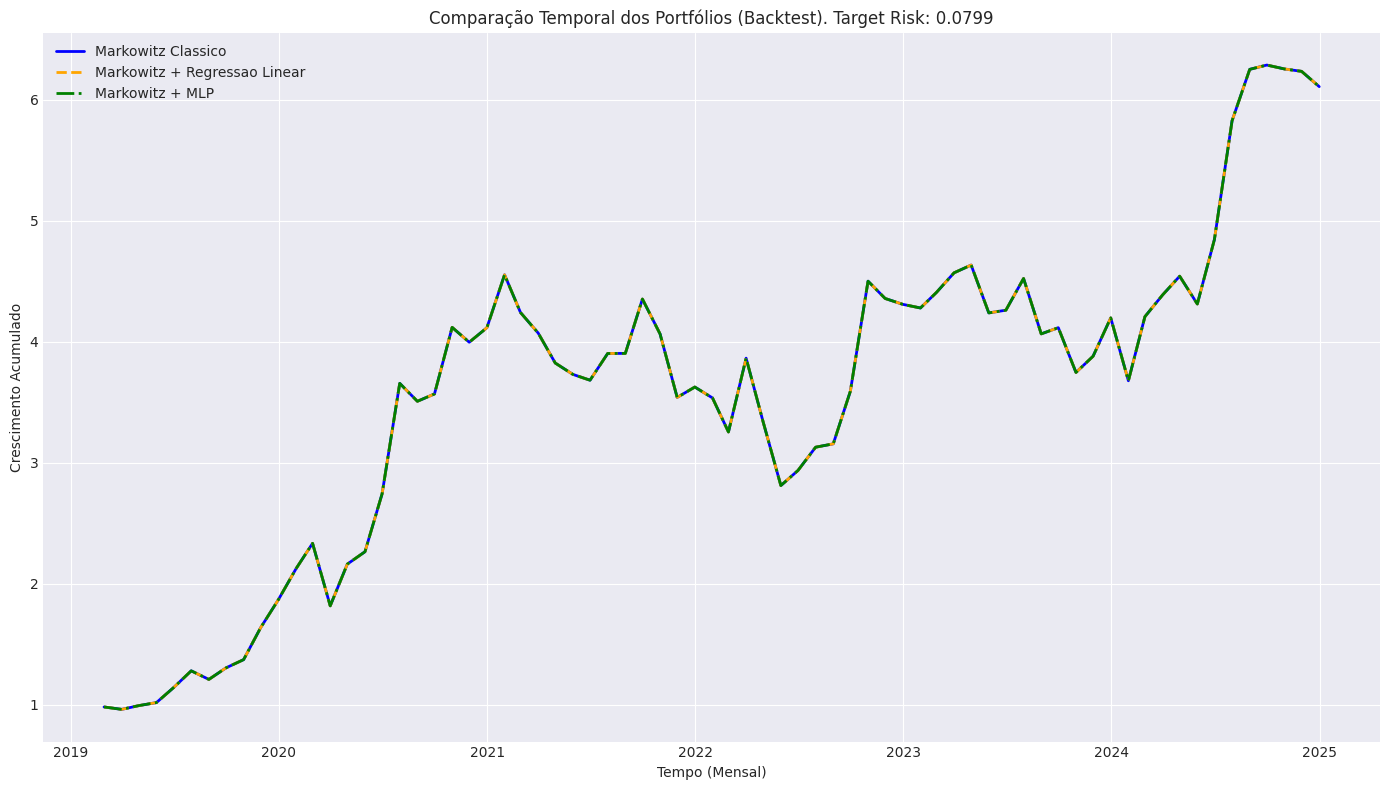

In [17]:
for target_risk in np.linspace(min_risk, max_risk, 5): 
    compare_time_series_local(models, target_risk=target_risk, w_list=w_list, lambdas=lambdas, ret_curve=ret_curve, vol_curve=vol_curve)

## 8. Cálculo de Métricas dos Portfólios

Agora vamos calcular as métricas financeiras (Sharpe, retorno anualizado, volatilidade) para cada modelo.


In [18]:

# CÁLCULO DE MÉTRICAS PARA CADA MODELO

# NOTA: Usamos otimização de Máximo Sharpe Ratio para garantir que as diferenças
# nas previsões de mu sejam refletidas nos pesos. Alternativamente, poderíamos usar
# lambda fixo (ex: 0.5) ou target_risk, mas máximo Sharpe é mais apropriado para
# comparação justa entre modelos.
# 
# risk_free_rate_period já está definido na célula 2 (configurações)

test_returns = returns.iloc[split_idx:]
all_metrics = []

print(" Calculando métricas dos portfólios usando Máximo Sharpe Ratio...")
print(f"   Taxa livre de risco mensal: {risk_free_rate_period:.4f} ({RISK_FREE_RATE_ANNUAL*100:.1f}% a.a.)")

for i, model in enumerate(models):
    name = model["name"]
    mean_returns = model["mean_returns"]
    cov_matrix = model["cov"]
    
    # Otimizar para máximo Sharpe Ratio
    # Isso garante que as diferenças em mu sejam refletidas nos pesos
    weights = get_optimal_portfolio_max_sharpe(
        mean_returns,
        cov_matrix,
        risk_free_rate=risk_free_rate_period
    )
    
    # Calcular retornos do portfólio no período de teste
    portfolio_ret = test_returns.dot(weights)
    
    # Avaliar portfólio
    metrics = evaluate_portfolio(
        portfolio_ret,
        risk_free_rate_annual=RISK_FREE_RATE_ANNUAL,
        periods_per_year=PERIODS_PER_YEAR,
        model_name=name
    )
    
    all_metrics.append(metrics)
    
    print(f"\n OK - {name}:")
    print(f"   Sharpe: {metrics['Sharpe']:.4f}")
    print(f"   Retorno Anualizado: {metrics['Annualized_Return']:.2%}")
    print(f"   Volatilidade Anualizada: {metrics['Annualized_Volatility']:.2%}")
    print(f"   Retorno Acumulado: {metrics['Cumulative_Return']:.2f}x")
    print(f"   Pesos: {dict(zip(tickers, weights.round(4)))}")

# Criar DataFrame com todas as métricas
metrics_df = pd.DataFrame(all_metrics)
print(f"\n Tabela de Métricas:")
print(metrics_df.to_string(index=False))


 Calculando métricas dos portfólios usando Máximo Sharpe Ratio...
   Taxa livre de risco mensal: 0.0117 (15.0% a.a.)

 OK - Markowitz Classico:
   Sharpe: 0.5432
   Retorno Anualizado: 33.16%
   Volatilidade Anualizada: 27.48%
   Retorno Acumulado: 4.41x
   Pesos: {'PETR3.SA': np.float64(0.0506), 'WEGE3.SA': np.float64(0.0), 'TOTS3.SA': np.float64(0.0), 'VALE3.SA': np.float64(0.0), 'EMBR3.SA': np.float64(0.0), 'VIVT3.SA': np.float64(0.3143), 'CSNA3.SA': np.float64(0.0), 'RADL3.SA': np.float64(0.0), 'PCAR3.SA': np.float64(0.0), 'PINE4.SA': np.float64(0.6351)}

 OK - Markowitz + Regressao Linear:
   Sharpe: 0.5911
   Retorno Anualizado: 35.73%
   Volatilidade Anualizada: 28.56%
   Retorno Acumulado: 4.86x
   Pesos: {'PETR3.SA': np.float64(0.0032), 'WEGE3.SA': np.float64(0.0), 'TOTS3.SA': np.float64(0.005), 'VALE3.SA': np.float64(0.0), 'EMBR3.SA': np.float64(0.0), 'VIVT3.SA': np.float64(0.1936), 'CSNA3.SA': np.float64(0.0), 'RADL3.SA': np.float64(0.0641), 'PCAR3.SA': np.float64(0.0), 'PIN

In [19]:

# GRÁFICO 5: Comparação de Sharpe Ratio

print("\n Gerando gráfico de comparação de Sharpe...")
plot_sharpe_comparison(
    metrics_df,
    save_path=str(CHARTS_DIR / "sharpe_comparison.png"),
    figsize=(10, 6)
)



 Gerando gráfico de comparação de Sharpe...
Gráfico salvo em: ../outputs/charts/sharpe_comparison.png


In [20]:
## 9. Exportação de Resultados em CSV


In [21]:

# SALVAR MÉTRICAS DOS PORTFÓLIOS

print(" Salvando métricas dos portfólios...")
save_all_metrics_comparison(
    all_metrics,
    save_path=str(MODELS_DIR / "all_models_metrics.csv")
)

# Salvar métricas individuais
for i, model in enumerate(models):
    save_portfolio_metrics(
        all_metrics[i],
        save_path=str(MODELS_DIR / f"{model['name'].lower().replace(' ', '_')}_metrics.csv")
    )


 Salvando métricas dos portfólios...
Comparação de métricas salva em: ../outputs/models/all_models_metrics.csv
Métricas salvas em: ../outputs/models/markowitz_classico_metrics.csv
Métricas salvas em: ../outputs/models/markowitz_+_regressao_linear_metrics.csv
Métricas salvas em: ../outputs/models/markowitz_+_mlp_metrics.csv


In [22]:

# SALVAR PESOS DOS PORTFÓLIOS (Máximo Sharpe)

print(" Salvando pesos dos portfólios (otimizados para máximo Sharpe)...")

for i, model in enumerate(models):
    mean_returns = model["mean_returns"]
    cov_matrix = model["cov"]
    
    # Usar mesma otimização de máximo Sharpe para consistência
    weights = get_optimal_portfolio_max_sharpe(
        mean_returns,
        cov_matrix,
        risk_free_rate=risk_free_rate_period
    )
    
    save_portfolio_weights(
        weights,
        tickers,
        model["name"],
        save_path=str(MODELS_DIR / f"{model['name'].lower().replace(' ', '_')}_weights.csv")
    )

 Salvando pesos dos portfólios (otimizados para máximo Sharpe)...
Pesos salvos em: ../outputs/models/markowitz_classico_weights.csv
Pesos salvos em: ../outputs/models/markowitz_+_regressao_linear_weights.csv
Pesos salvos em: ../outputs/models/markowitz_+_mlp_weights.csv


In [23]:

# SALVAR PREVISÕES DE RETORNOS (mu)

print(" Salvando previsões de retornos...")

save_predicted_returns(
    pure_monthly,
    "Markowitz_Classico",
    save_path=str(PREDICTIONS_DIR / "markowitz_classico_predictions.csv")
)

save_predicted_returns(
    pred_lr_monthly,
    "Regressao_Linear",
    save_path=str(PREDICTIONS_DIR / "linear_regression_predictions.csv")
)

save_predicted_returns(
    pred_mlp_monthly,
    "MLP",
    save_path=str(PREDICTIONS_DIR / "mlp_predictions.csv")
)

print("\n  Todos os resultados foram salvos!")

 Salvando previsões de retornos...
Previsões salvas em: ../outputs/predictions/markowitz_classico_predictions.csv
Previsões salvas em: ../outputs/predictions/linear_regression_predictions.csv
Previsões salvas em: ../outputs/predictions/mlp_predictions.csv

  Todos os resultados foram salvos!


In [24]:

# TABELA 1: Métricas dos Portfólios

print(" TABELA 1: Métricas dos Portfólios")
print("=" * 80)

portfolio_metrics_table = metrics_df[[
    'Model', 
    'Sharpe', 
    'Annualized_Return', 
    'Annualized_Volatility', 
    'Cumulative_Return'
]].copy()

portfolio_metrics_table['Annualized_Return'] = portfolio_metrics_table['Annualized_Return'].apply(lambda x: f"{x:.2%}")
portfolio_metrics_table['Annualized_Volatility'] = portfolio_metrics_table['Annualized_Volatility'].apply(lambda x: f"{x:.2%}")
portfolio_metrics_table['Sharpe'] = portfolio_metrics_table['Sharpe'].apply(lambda x: f"{x:.4f}")
portfolio_metrics_table['Cumulative_Return'] = portfolio_metrics_table['Cumulative_Return'].apply(lambda x: f"{x:.2f}x")

print(portfolio_metrics_table.to_string(index=False))

# Salvar tabela
portfolio_metrics_table.to_csv(MODELS_DIR / "portfolio_metrics_table.csv", index=False)


 TABELA 1: Métricas dos Portfólios
                       Model Sharpe Annualized_Return Annualized_Volatility Cumulative_Return
          Markowitz Classico 0.5432            33.16%                27.48%             4.41x
Markowitz + Regressao Linear 0.5911            35.73%                28.56%             4.86x
             Markowitz + MLP 0.5718            34.33%                27.66%             4.63x


In [25]:

# TABELA 2: Comparação de mu (Retornos Esperados) por Modelo

print("\n TABELA 2: Retornos Esperados (mu) por Modelo")
print("=" * 80)

mu_comparison = pd.DataFrame({
    'Ticker': tickers,
    'Markowitz_Classico': pure_monthly.values,
    'Regressao_Linear': pred_lr_monthly.values,
    'MLP': pred_mlp_monthly.values
})

mu_comparison_display = mu_comparison.copy()
for col in ['Markowitz_Classico', 'Regressao_Linear', 'MLP']:
    mu_comparison_display[col] = mu_comparison_display[col].apply(lambda x: f"{x:.6f}")

print(mu_comparison_display.to_string(index=False))

# Salvar tabela
mu_comparison.to_csv(PREDICTIONS_DIR / "mu_comparison_table.csv", index=False)



 TABELA 2: Retornos Esperados (mu) por Modelo
  Ticker Markowitz_Classico Regressao_Linear       MLP
PETR3.SA           0.026069         0.023651  0.032619
WEGE3.SA           0.002965         0.002605 -0.001425
TOTS3.SA           0.012517         0.014608  0.009571
VALE3.SA           0.011167         0.012602  0.017378
EMBR3.SA          -0.002338        -0.004034  0.001607
VIVT3.SA           0.024329         0.022570  0.028327
CSNA3.SA           0.015289         0.017923  0.023778
RADL3.SA           0.015533         0.016262  0.017170
PCAR3.SA           0.008074         0.007912  0.014670
PINE4.SA           0.029889         0.033190  0.042230


In [26]:

# TABELA 3: Pesos dos Portfólios por Modelo
# 
# IMPORTANTE: Esta tabela mostra os pesos para um RISCO-ALVO específico (target_risk_mean),
# que é o risco médio das fronteiras eficientes. Esses pesos são DIFERENTES dos pesos
# usados nas métricas (que são de Máximo Sharpe). 
#
# Os pesos aqui podem mostrar concentração extrema (ex: 100% em um ativo) porque
# estamos escolhendo um ponto específico na fronteira eficiente, não o portfólio
# de melhor Sharpe. Valores muito pequenos (1e-16) são ruído numérico da otimização.

print("\n TABELA 3A: Pesos dos Portfólios (Target Risk - para comparação de fronteiras)")
print("=" * 80)
print("NOTA: Estes pesos são para um risco-alvo fixo na fronteira eficiente teórica.")
print("      Eles NÃO correspondem aos pesos usados nas métricas de performance.\n")

weights_comparison = pd.DataFrame({'Ticker': tickers})

for i, model in enumerate(models):
    # Encontrar melhor lambda para o risco-alvo
    min_diff = float('inf')
    best_idx = 0
    for j, vol in enumerate(vol_curve[i]):
        diff = abs(vol - target_risk_mean)
        if diff < min_diff:
            min_diff = diff
            best_idx = j
    
    weights = w_list[i][best_idx]
    weights_comparison[model['name']] = weights

weights_comparison_display = weights_comparison.copy()
for col in weights_comparison.columns[1:]:
    weights_comparison_display[col] = weights_comparison_display[col].apply(lambda x: f"{x:.4f}")

print(weights_comparison_display.to_string(index=False))

# Salvar tabela
weights_comparison.to_csv(MODELS_DIR / "weights_comparison_table.csv", index=False)

# TABELA 3B: Pesos dos Portfólios (Máximo Sharpe - usados nas métricas)
print("\n" + "=" * 80)
print(" TABELA 3B: Pesos dos Portfólios (Máximo Sharpe - usados nas métricas)")
print("=" * 80)
print("NOTA: Estes são os pesos que foram usados para calcular as métricas de performance.\n")

weights_max_sharpe = pd.DataFrame({'Ticker': tickers})

for i, model in enumerate(models):
    mean_returns = model["mean_returns"]
    cov_matrix = model["cov"]
    
    # Usar mesma otimização de máximo Sharpe usada nas métricas
    weights = get_optimal_portfolio_max_sharpe(
        mean_returns,
        cov_matrix,
        risk_free_rate=risk_free_rate_period
    )
    
    weights_max_sharpe[model['name']] = weights

weights_max_sharpe_display = weights_max_sharpe.copy()
for col in weights_max_sharpe.columns[1:]:
    weights_max_sharpe_display[col] = weights_max_sharpe_display[col].apply(lambda x: f"{x:.4f}")

print(weights_max_sharpe_display.to_string(index=False))

# Salvar tabela de pesos de máximo Sharpe
weights_max_sharpe.to_csv(MODELS_DIR / "weights_max_sharpe_comparison.csv", index=False)



 TABELA 3A: Pesos dos Portfólios (Target Risk - para comparação de fronteiras)
NOTA: Estes pesos são para um risco-alvo fixo na fronteira eficiente teórica.
      Eles NÃO correspondem aos pesos usados nas métricas de performance.

  Ticker Markowitz Classico Markowitz + Regressao Linear Markowitz + MLP
PETR3.SA             0.0023                       0.0000          0.0061
WEGE3.SA             0.0000                       0.0000          0.0000
TOTS3.SA             0.0541                       0.0584          0.0150
VALE3.SA             0.0000                       0.0000          0.0000
EMBR3.SA             0.0000                       0.0000          0.0000
VIVT3.SA             0.2707                       0.2097          0.1841
CSNA3.SA             0.0000                       0.0000          0.0000
RADL3.SA             0.0898                       0.0993          0.0486
PCAR3.SA             0.1267                       0.1350          0.2237
PINE4.SA             0.4564          